Installation of libraries

In [ ]:
!pip install matplotlib numpy langdetect networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=e308fdd238fbb86420dde8d516c38953fadba1451c48448097e166ab09726f1a
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


Importing libraries

In [ ]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from langdetect import detect

Connect to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Create dataframes (SDGs 1, 2, 4 e 5)

In [ ]:
# Caminho da pasta dentro do seu Google Drive com os arquivos csv
folder_path = '/content/drive/My Drive/ED2 - Projetos/Segunda unidade/data'

# Caminho completo para o arquivo
file_path1 = os.path.join(folder_path, 'sdg1.csv')
file_path2 = os.path.join(folder_path, 'sdg2.csv')
file_path4 = os.path.join(folder_path, 'sdg4.csv')
file_path5 = os.path.join(folder_path, 'sdg5.csv')

# Carregar o arquivo CSV em um DataFrame
df1 = pd.read_csv(file_path1)
df2 = pd.read_csv(file_path2)
df4 = pd.read_csv(file_path4)
df5 = pd.read_csv(file_path5)

Create graph for each SDG

In [ ]:
# Função para extrair afiliações
def extract_affiliations(authors_with_affiliations):
    affiliations = []
    authors_list = authors_with_affiliations.split(';')  # Separa cada autor
    for author_info in authors_list:
        parts = author_info.split(',')
        if len(parts) > 1:
            if detect(parts[1]) == 'pt':
              affiliation = parts[1].strip()
              affiliations.append(affiliation)
            elif detect(parts[1]) == 'en':
              if len(parts) > 2:
                affiliation = parts[2].strip()
              else:
                affiliation = parts[1].strip()
              affiliations.append(affiliation)
            else:
              affiliation = parts[1].strip()
              affiliations.append(affiliation)
        else:
            affiliations.append('Unknown')  # Caso não tenha afiliação
    return affiliations

In [ ]:
#Função para criar grafo de co-autoria para cada SDG
def create_graph(df, graph):
  # Itera sobre as linhas do DataFrame
  for _, row in df.iterrows():
    authors = row['Authors'].split(';')  # Separa os autores por ponto e vírgula
    authors_id = row['Author(s) ID'].split(';')  # Separa os autores por ponto e vírgula
    affiliations = extract_affiliations(row['Authors with affiliations'])  # Extrai as afiliações

  # Cria um dicionário para mapear IDs dos autores a nomes e afiliações
    author_data = {}
    for i in range(len(authors)):
      author_name = authors[i].strip()  # Remove espaços em branco extras
      author_id = authors_id[i].strip() if i < len(authors_id) else 'Unknown'  # Pega o ID do autor
      affiliation = affiliations[i].split(', ')[0] if i < len(affiliations) else 'Unknown'  # Pega a primeira instituição
      author_data[author_id] = {'name': author_name, 'affiliation': affiliation}

  # Adiciona os vértices (autores) ao grafo
    for author_id, data in author_data.items():
      if not graph.has_node(author_id):
        graph.add_node(author_id, name=data['name'], affiliation=data['affiliation'])

  # Adiciona as arestas (coautorias) ao grafo
    author_ids = list(author_data.keys())
    for i in range(len(author_ids)):
        for j in range(i + 1, len(author_ids)):
            graph.add_edge(author_ids[i], author_ids[j])

In [ ]:
# Crie um grafo vazio
graph1 = nx.Graph()
graph2 = nx.Graph()
graph4 = nx.Graph()
graph5 = nx.Graph()

# Chame a função para criar os grafos
create_graph(df1, graph1)
create_graph(df2, graph2)
create_graph(df4, graph4)
create_graph(df5, graph5)



Create bipartite graph on assortivity in relation to the degree of network nodes (Request 2)

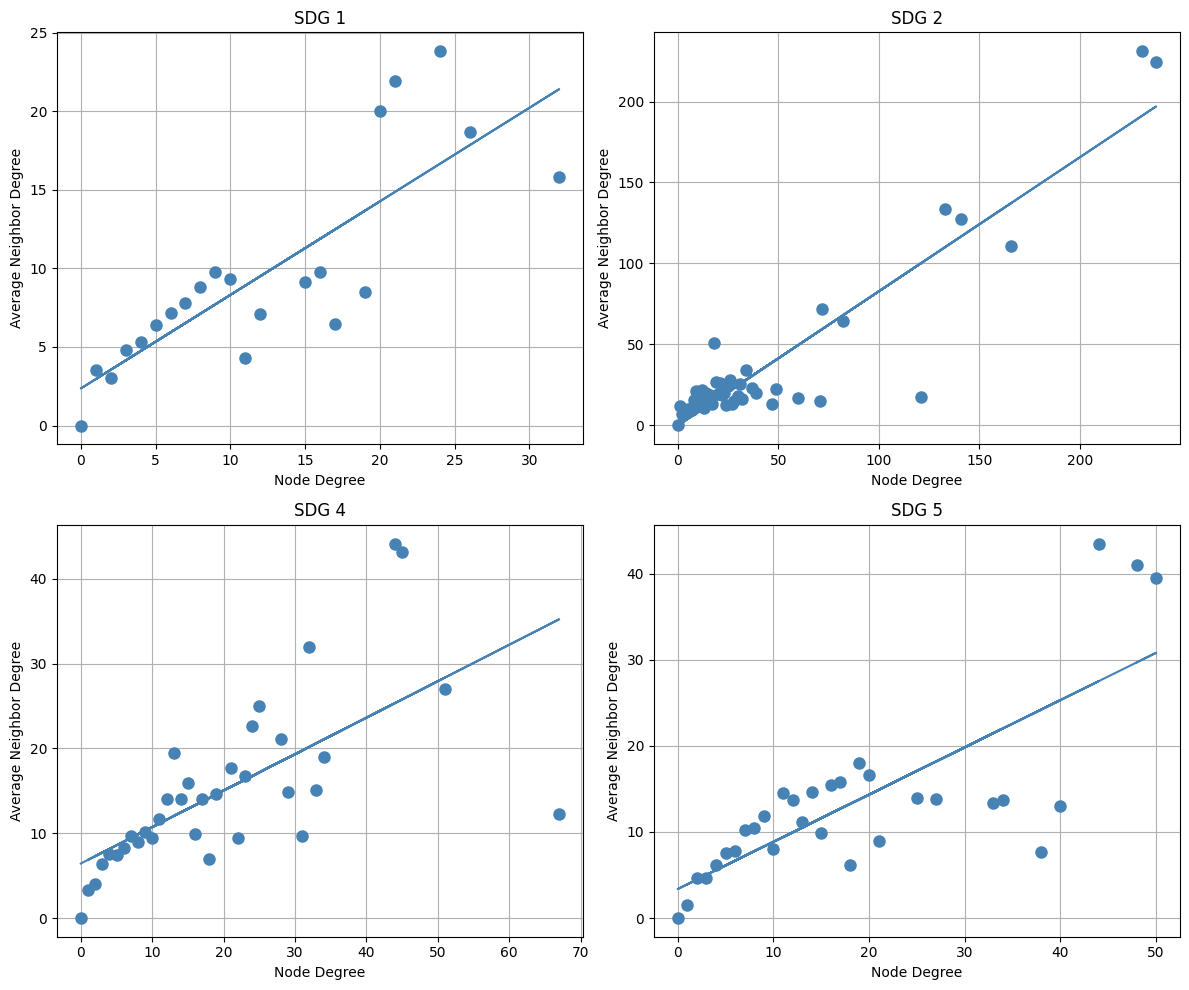

In [ ]:
degree1, avg_neigh_degree1 = zip(*nx.average_degree_connectivity(graph1).items())
degree2, avg_neigh_degree2 = zip(*nx.average_degree_connectivity(graph2).items())
degree4, avg_neigh_degree4 = zip(*nx.average_degree_connectivity(graph4).items())
degree5, avg_neigh_degree5 = zip(*nx.average_degree_connectivity(graph5).items())

# Criar uma figura com 2 linhas e 2 colunas de gráficos
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Função para plotar um gráfico
def plot_graph(ax, degree, avg_neigh_degree, title):
    ax.plot(degree, avg_neigh_degree, 'o', color ='#4682B4', markersize=8)
    coefficients = np.polyfit(degree, avg_neigh_degree, 1)
    poly = np.poly1d(coefficients)
    ax.plot(degree, poly(degree), color='#4682B4')
    ax.set_xlabel('Node Degree')
    ax.set_ylabel('Average Neighbor Degree')
    ax.set_title(title)
    ax.grid(True)

# Plotar em cada eixo
plot_graph(axs[0, 0], degree1, avg_neigh_degree1, 'SDG 1')
plot_graph(axs[0, 1], degree2, avg_neigh_degree2, 'SDG 2')
plot_graph(axs[1, 0], degree4, avg_neigh_degree4, 'SDG 4')
plot_graph(axs[1, 1], degree5, avg_neigh_degree5, 'SDG 5')

# Ajustar layout
plt.tight_layout()
plt.show()

Create Table (Request 3)

In [ ]:
table = {
    'Rede': ['SDG 1', 'SDG 2', 'SDG 4', 'SDG 5'],
    'Número de Vértices': [graph1.number_of_nodes(), graph2.number_of_nodes(), graph4.number_of_nodes(), graph5.number_of_nodes()],
    'Número de Arestas': [graph1.number_of_edges(), graph2.number_of_edges(), graph4.number_of_edges(), graph5.number_of_edges()],
    'Degree Assortativity Coefficient': [nx.degree_assortativity_coefficient(graph1), nx.degree_assortativity_coefficient(graph2), nx.degree_assortativity_coefficient(graph4), nx.degree_assortativity_coefficient(graph5)],
    'Quantidade de Componentes Conectados': [nx.number_connected_components(graph1), nx.number_connected_components(graph2), nx.number_connected_components(graph4), nx.number_connected_components(graph5)],
    'Tamanho do Componente Gigante': [len(max(nx.connected_components(graph1), key=len)), len(max(nx.connected_components(graph2), key=len)), len(max(nx.connected_components(graph4), key=len)), len(max(nx.connected_components(graph5), key=len))],
    'Coeficiente de Clustering': [nx.average_clustering(graph1), nx.average_clustering(graph2), nx.average_clustering(graph4), nx.average_clustering(graph5)]
}

# Cria o DataFrame
table_metrics = pd.DataFrame(table)


In [ ]:
print(table_metrics.to_markdown(index=False))

| Rede   |   Número de Vértices |   Número de Arestas |   Degree Assortativity Coefficient |   Quantidade de Componentes Conectados |   Tamanho do Componente Gigante |   Coeficiente de Clustering |
|:-------|---------------------:|--------------------:|-----------------------------------:|---------------------------------------:|--------------------------------:|----------------------------:|
| SDG 1  |                  400 |                1590 |                           0.88345  |                                     50 |                              86 |                    0.878746 |
| SDG 2  |                 1759 |               44798 |                           0.989253 |                                    100 |                             892 |                    0.94686  |
| SDG 4  |                 1224 |                5274 |                           0.823567 |                                    129 |                             207 |                    0.871056 |
| SDG 5  |